In [6]:
# train_efficientnet_dr.py  ──────────────────────────────────────────────
import os, time, math, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch, torchvision
from torch import nn, optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms

# ---- your local helpers ------------------------------------------------
from hdr.EfficientNet import *            
from hdr.preprocess   import *  

In [4]:
# ───────────────────────────── constants ──────────────────────────────
IMG_SIZE      = 300
DATA_DIR      = "D:\\DiabeticRetinoplastyDataset\\diabetic-retinopathy-detection\\train.zip\\train"
CSV_DIR       = "D:\\DiabeticRetinoplastyDataset\\diabetic-retinopathy-detection\\trainLabels\\"
RUN_NAME      = f"effnetb3_{int(time.time())}"
CKPT_DIR      = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True)

DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES   = 5
BATCH_SIZE    = 32       # 48‒64 w/ more VRAM
EPOCHS        = 25
LR            = 1e-4
WEIGHT_DECAY  = 2e-5
MAX_NORM      = 5.0      # grad-clip
SEED          = 42

torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# TRAINING LABELS
print(f"\nTraining labels stored in [{os.listdir(CSV_DIR)[0]}]")

try:
    trainlabel = pd.read_csv(CSV_DIR + os.listdir(CSV_DIR)[0])
except Exception as e:
    print("\nTraining Labels cannot be loaded", e)

# ─────────────────────────── dataset ingest ───────────────────────────
print("\n» Loading label CSV …")
csv_file = os.listdir(CSV_DIR)[0]
labels   = pd.read_csv(os.path.join(CSV_DIR, csv_file))

train_imgs = os.listdir(DATA_DIR)
train_ids  = [p.split('.')[0] for p in train_imgs]
labels_df  = labels[labels['image'].isin(train_ids)].reset_index(drop=True)
print(f"✓ Training set: {len(labels_df)} images")

# class imbalance → weight per sample
class_counts   = labels_df['level'].value_counts().sort_index().values
class_weights  = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = labels_df['level'].map(lambda x: class_weights[x]).values

# ─────────────────────────── transforms ───────────────────────────────
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.25, 0.25, 0.15, 0.05),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ••• If your dataset constructor matches (root, transform, labels_df) •••
train_ds = DiabeticRetinopathyDataset(DATA_DIR, train_tf, labels_df)
val_ds   = DiabeticRetinopathyDataset(DATA_DIR, val_tf,   labels_df)   # ← same df

class_counts  = labels_df['level'].value_counts().sort_index().values
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.double)   # shape [5]

# vectorised index -- no Python loop, no map()
sample_weights = class_weights[labels_df['level'].values]              # shape [N]  ← torch.double
# ------------------------------------------------------------------

sampler = WeightedRandomSampler(sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=sampler, num_workers=4,
                          pin_memory=True, drop_last=True)

val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4,
                          pin_memory=True)          # full pass, no sampling


Training labels stored in [trainLabels.csv]

» Loading label CSV …
✓ Training set: 35126 images


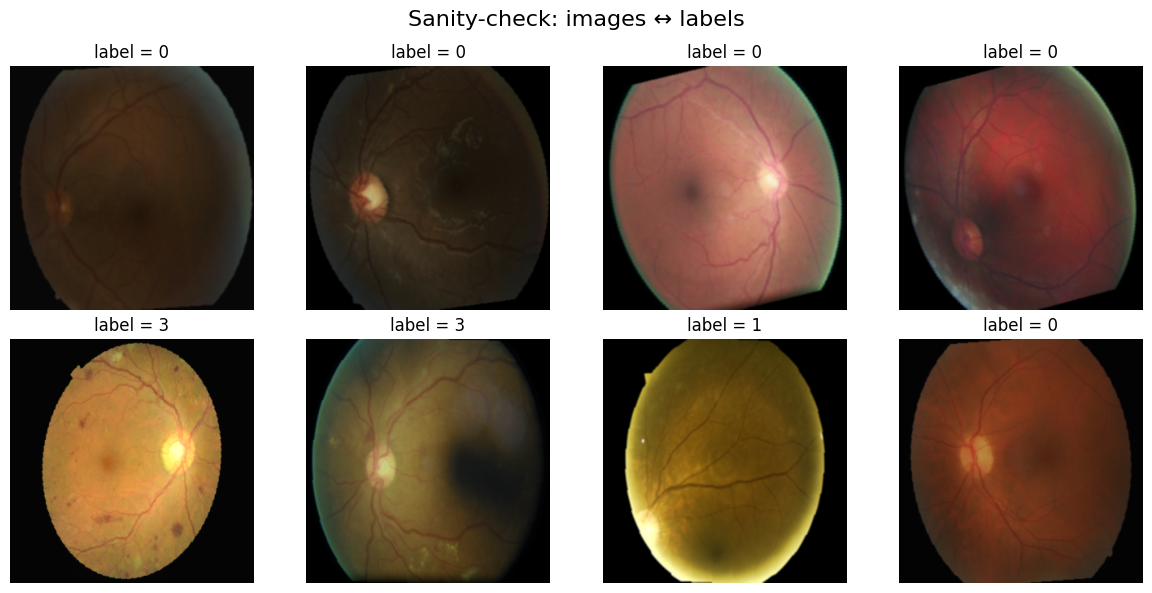

In [5]:
# ── 3 .  QUICK VISUAL INSPECTION ──────────────────────────────────────
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

_IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
_IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(tensor):
    """
    Undo the torchvision.transforms.Normalize step so we can display the image.
    Expects a tensor in [0,1] *after* ToTensor() but *before* Normalize().
    """
    return torch.clamp(tensor * _IMAGENET_STD + _IMAGENET_MEAN, 0, 1)

# Pull one mini-batch
imgs, lbls = next(iter(train_loader))

# Plot the first 8 samples
n_show = min(8, imgs.size(0))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Sanity-check: images ↔ labels", fontsize=16)

for i in range(n_show):
    ax = axes[i // 4, i % 4]
    img = denormalize(imgs[i].cpu())
    ax.imshow(F.to_pil_image(img))
    ax.set_title(f"label = {lbls[i].item()}")
    ax.axis("off")

# If you want to save instead of (or in addition to) showing:
# fig.savefig(CKPT_DIR / f"{RUN_NAME}_sample_batch.png", dpi=150)

plt.tight_layout()
plt.show()

In [ ]:
# ───────────────────────────── model & opt ────────────────────────────
model = build_efficientnet_b3(NUM_CLASSES, pretrained=True).to(DEVICE)
# Freeze params
for param in model.features.parameters():   # backbone = .features
    param.requires_grad = False

criterion  = nn.CrossEntropyLoss()
optimizer  = optimizer = optim.AdamW(
    model.classifier.parameters(),     # ← just the last layer
    lr=LR, weight_decay=WEIGHT_DECAY
)

scheduler  = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2)
scaler = torch.cuda.amp.GradScaler(enabled=False)   # disables AMP

c:\Users\mj\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to C:\Users\mj/.cache\torch\hub\master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to C:\Users\mj/.cache\torch\hub\checkpoints\efficientnet_b3_ra2-cf98

In [ ]:
# ───────────────────────────── training loop ──────────────────────────
history = []
best_val = math.inf

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    epoch_loss, correct, seen = 0.0, 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(DEVICE, non_blocking=True), lbls.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(imgs)
            loss   = criterion(logits, lbls)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        scaler.step(optimizer); scaler.update()

        epoch_loss += loss.item() * imgs.size(0)
        correct    += (logits.argmax(1) == lbls).sum().item()
        seen       += imgs.size(0)

    scheduler.step()
    train_loss = epoch_loss / seen
    train_acc  = correct / seen

    # ── validation ──
    model.eval()
    v_loss, v_corr, v_seen = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss += loss.item() * x.size(0)
            v_corr += (logits.argmax(1) == y).sum().item()
            v_seen += x.size(0)
    val_loss, val_acc = v_loss / v_seen, v_corr / v_seen

    history.append(dict(epoch=epoch, train_loss=train_loss,
                        val_loss=val_loss, val_acc=val_acc))

    # checkpoint
    ckpt = CKPT_DIR / f"{RUN_NAME}_e{epoch:02d}.pth"
    torch.save(model.state_dict(), ckpt)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), CKPT_DIR / f"{RUN_NAME}_best.pth")

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train {train_loss:.4f}/{train_acc:.3%} | "
          f"val {val_loss:.4f}/{val_acc:.3%}")

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\mj\AppData\Local\Temp\ipykernel_5840\3184044513.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
# ──────────────────────────── loss curve ─────────────────────────────
df = pd.DataFrame(history)
plt.figure(figsize=(7,4))
plt.plot(df.epoch, df.train_loss, label="train")
plt.plot(df.epoch, df.val_loss,   label="val")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("EffNet-B3 DR training"); plt.legend(); plt.grid(alpha=.3)
plot_path = CKPT_DIR / f"{RUN_NAME}_loss.png"
plt.tight_layout(); plt.savefig(plot_path, dpi=150); plt.show()
print("✔ saved curve →", plot_path)

In [ ]:
# dump training log
with open(f"{RUN_NAME}_log.json", "w") as f: json.dump(history, f, indent=2)
print("\nTraining complete.")